---

## 1. Preparação dos Dados

---

#### a) **Importando os arquivos CSV do dataset e as bibliotecas necessárias**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import folium
from folium.plugins import HeatMap

# Caminho para a pasta dos datasets
dataset_path = "dataset"

# Lista todos os arquivos CSV na pasta
csv_files = [f for f in os.listdir(dataset_path) if f.endswith('.csv')]

# Cria um dicionário para armazenar os dataframes
dataframes = {}

# Importa todos os arquivos CSV como dataframes
for file in csv_files:
    df_name = file.replace('.csv', '')
    dataframes[df_name] = pd.read_csv(os.path.join(dataset_path, file))

customers_df = dataframes['customers']
order_items_df = dataframes['order_items']
sellers_df = dataframes['sellers']
products_df = dataframes['products']
product_category_name_translation_df = dataframes['product_category_name_translation']
order_payments_df = dataframes['order_payments']
orders_df = dataframes['orders']
order_reviews_df = dataframes['order_reviews']
geolocation_df = dataframes['geolocation']

#### b) **Realizando a limpeza necessária** 

In [2]:
for name, df in dataframes.items():
    print(f"{name}:")
    print(df.isnull().sum())
    print("-" * 40)

customers:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64
----------------------------------------
order_items:
order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64
----------------------------------------
sellers:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64
----------------------------------------
products:
product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64
---------------------------------------

In [3]:
for name, df in dataframes.items():
    duplicates = df.duplicated().sum()
    print(f"{name}: {duplicates} duplicatas")

customers: 0 duplicatas
order_items: 0 duplicatas
sellers: 0 duplicatas
products: 0 duplicatas
product_category_name_translation: 0 duplicatas
order_payments: 0 duplicatas
orders: 0 duplicatas
order_reviews: 0 duplicatas
geolocation: 261831 duplicatas


- Podemos perceber que nenhuma das colunas relevantes para a análise possuem valores nulos, ao mesmo tempo que somente as linhas de "geolocation"  
possuem duplicatas o que não é um problemas pois essa tabela contém as localizações dos vendedores e dos compradores que podem se repetir sem problemas
  
- Também destaca-se a **qualidade desses dados** visto que ainda não foi necessária nenhuma modificação nos datasets

#### c) **Fazendo a normalização das colunas**

In [4]:
order_items_df.describe()

,order_item_id,price,freight_value
count,112650.000000,112650.000000,112650.000000
mean,1.197834,120.653739,19.990320
std,0.705124,183.633928,15.806405
min,1.000000,0.850000,0.000000
25%,1.000000,39.900000,13.080000
50%,1.000000,74.990000,16.260000
75%,1.000000,134.900000,21.150000
max,21.000000,6735.000000,409.680000


In [5]:
order_payments_df.describe()

,payment_sequential,payment_installments,payment_value
count,103886.000000,103886.000000,103886.000000
mean,1.092679,2.853349,154.100380
std,0.706584,2.687051,217.494064
min,1.000000,0.000000,0.000000
25%,1.000000,1.000000,56.790000
50%,1.000000,1.000000,100.000000
75%,1.000000,4.000000,171.837500
max,29.000000,24.000000,13664.080000


- Dado o contexto do problema, os atributos que podem ser problemáticos numericamente e que talvez precisem ser normalizados podem estar relacionados a precificação mas analisando as estatísticas gerais das tabelas relacionadas a valores monetários vemos que existem outliers mas que condizem com o negócio

#### d) **Criando um modelo relacional e conectando as tabelas adequadamente**

- Como os problemas a serem resolvidos e as perguntas a serem respondidas diferem bastamtem optarei por realizar os **JOINS "sob demanda"**, ou seja caso uma pergunta necessite de mais de uma tabela a conexão será realizada na resolução da pergunta. Caso seja possível reutilizarei as conexões para evitar processamento descessário  
  
- Para facilitar o entendimento dos dados produzi um diagrama Entidade-Relacionamento que servirá de guia para o projeto, disponível no link:  
[diagrama](https://miro.com/app/board/uXjVI0LJsEA=/?share_link_id=70608596602)

![diagrama](diagrama.jpg)

---

## 2. Análise Exploratória de Dados 

---

#### a) **Volume de pedidos por mês / Sazonalidade nas vendas**

In [6]:
# Converter a coluna de data para datetime
orders_df['order_purchase_timestamp'] = pd.to_datetime(orders_df['order_purchase_timestamp'])

# Criar coluna com número do mês
orders_df['mes'] = orders_df['order_purchase_timestamp'].dt.month

# Contar número de pedidos por mês (ignorando o ano)
total_por_mes = orders_df.groupby('mes').size().reset_index(name='num_pedidos')

# Adicionar nome dos meses
meses_nome = ['Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 'Junho', 
              'Julho', 'Agosto', 'Setembro', 'Outubro', 'Novembro', 'Dezembro']

total_por_mes['mes_nome'] = total_por_mes['mes'].apply(lambda x: meses_nome[x-1])

# Exibir resultado
display(total_por_mes[['mes_nome', 'num_pedidos']])


,mes_nome,num_pedidos
0,Janeiro,8069
1,Fevereiro,8508
2,Março,9893
3,Abril,9343
4,Maio,10573
5,Junho,9412
6,Julho,10318
7,Agosto,10843
8,Setembro,4305
9,Outubro,4959


- Podemos afirmar que sim, existe sazonalidade nas vendas, o segundo quadrimestre possui a maior quantidade de pedidos e o terceiro quadrimestre possui um desempenho muito abaixo dos outros

#### b) **Distribuição do tempo de entrega dos pedidos**

- Considerei o "tempo de entrega" o intervalo de dias entre a aprovação do pagamento e a chegada do produto

In [7]:
# Converter as colunas para datetime, se ainda não estiverem
orders_df['order_approved_at'] = pd.to_datetime(orders_df['order_approved_at'])
orders_df['order_delivered_customer_date'] = pd.to_datetime(orders_df['order_delivered_customer_date'])

# Calcular a diferença em dias
orders_df['tempo_de_entrega'] = (orders_df['order_delivered_customer_date'] - orders_df['order_approved_at']).dt.days
orders_df['tempo_de_entrega'] = orders_df['tempo_de_entrega'].fillna(0).astype(int)

display((orders_df.groupby('tempo_de_entrega')
                    .size().
                    reset_index(name='num_pedidos'))
                    .sort_values(by='num_pedidos', ascending=False)
                    .head(25))

media_tempo_entrega = (orders_df['tempo_de_entrega'].sum() / orders_df['tempo_de_entrega'].count())
print(f"Média de tempo de entrega (em dias): {media_tempo_entrega:.2f}")

,tempo_de_entrega,num_pedidos
14,7,7715
13,6,7580
15,8,6389
12,5,6176
16,9,5869
17,10,5406
11,4,4975
18,11,4819
19,12,4471
20,13,4333


Média de tempo de entrega (em dias): 11.29


- Temos que a maioria dos pedidos é entregue entre 5 a 20 dias com um número grande de entregas realizadas no mesmo dia, além disso temos em média  
11 dias para que o produto seja entregue

#### c) **Relação entre o valor do frete e a distância de entrega**

- Para resolver essa pergunta utilizarei as tabelas "orders", "customers", "order_items" e "sellers" para obter respectivamente o "order_id", ("customer_city" e "customer_state"), "freight_value", ("seller_city" e "seller_state") e com esses dados poderei obter informações importantes sobre a distância de entrega

In [8]:
orders_customers = orders_df.merge(customers_df, on='customer_id', how='inner')[['order_id', 'customer_city', 'customer_id','customer_state', 'customer_unique_id','customer_zip_code_prefix']]

orders_customers_items = orders_customers.merge(order_items_df[['order_id', 'seller_id', 'freight_value']], on='order_id', how='inner')

orders_customers_items_sellers = orders_customers_items.merge(
    sellers_df[['seller_id', 'seller_city', 'seller_state']],
    on='seller_id',
    how='left'
)

orders_customers_items_sellers = orders_customers_items_sellers.drop(columns=['seller_id'])
display(orders_customers_items_sellers.head())

,order_id,customer_city,customer_id,customer_state,customer_unique_id,customer_zip_code_prefix,freight_value,seller_city,seller_state
0,e481f51cbdc54678b7cc49136f2d6af7,sao paulo,9ef432eb6251297304e76186b10a928d,SP,7c396fd4830fd04220f754e42b4e5bff,3149,8.72,maua,SP
1,53cdb2fc8bc7dce0b6741e2150273451,barreiras,b0830fb4747a6c6d20dea0b8c802d7ef,BA,af07308b275d755c9edb36a90c618231,47813,22.76,belo horizonte,SP
2,47770eb9100c2d0c44946d9cf07ec65d,vianopolis,41ce2a54c0b03bf3443c3d931a367089,GO,3a653a41f6f9fc3d2a113cf8398680e8,75265,19.22,guariba,SP
3,949d5b44dbf5de918fe9c16f97b45f8a,sao goncalo do amarante,f88197465ea7920adcdbec7375364d82,RN,7c142cf63193a1473d2e66489a9ae977,59296,27.20,belo horizonte,MG
4,ad21c59c0840e6cb83a9ceb5573f8159,santo andre,8ab97904e6daea8866dbdbc4fb7aad2c,SP,72632f0f9dd73dfee390c9b22eb56dd6,9195,8.72,mogi das cruzes,SP


- Dividirei os pedidos entre "Mesma Cidade", "Mesmo Estado", e "Mesma Região". Assim podemos ter uma visão mais geral das distâncias

In [9]:
orders_customers_items_sellers['same_city'] = np.where(
    orders_customers_items_sellers['customer_city'].str.lower() == orders_customers_items_sellers['seller_city'].str.lower(),
    'yes', 'no'
)
orders_customers_items_sellers['same_state'] = np.where(
    orders_customers_items_sellers['customer_state'].str.lower() == orders_customers_items_sellers['seller_state'].str.lower(),
    'yes', 'no'
)

estado_para_regiao = {
    'AC': 'NO', 'AP': 'NO', 'AM': 'NO', 'PA': 'NO', 'RO': 'NO', 'RR': 'NO', 'TO': 'NO',
    'AL': 'NE', 'BA': 'NE', 'CE': 'NE', 'MA': 'NE', 'PB': 'NE', 'PE': 'NE', 'PI': 'NE', 'RN': 'NE', 'SE': 'NE',
    'DF': 'CO', 'GO': 'CO', 'MT': 'CO', 'MS': 'CO',
    'ES': 'SE', 'MG': 'SE', 'RJ': 'SE', 'SP': 'SE',
    'PR': 'SU', 'RS': 'SU', 'SC': 'SU'
}

orders_customers_items_sellers['customer_region'] = orders_customers_items_sellers['customer_state'].map(
    estado_para_regiao
).fillna('Outros')

orders_customers_items_sellers['seller_region'] = orders_customers_items_sellers['seller_state'].map(
    estado_para_regiao
).fillna('Outros')

orders_customers_items_sellers['same_region'] = np.where(
    orders_customers_items_sellers['customer_region'] == orders_customers_items_sellers['seller_region'],
    'yes', 'no'
)

orders_customers_items_sellers 

,order_id,customer_city,customer_id,customer_state,customer_unique_id,customer_zip_code_prefix,freight_value,seller_city,seller_state,same_city,same_state,customer_region,seller_region,same_region
0,e481f51cbdc54678b7cc49136f2d6af7,sao paulo,9ef432eb6251297304e76186b10a928d,SP,7c396fd4830fd04220f754e42b4e5bff,3149,8.72,maua,SP,no,yes,SE,SE,yes
1,53cdb2fc8bc7dce0b6741e2150273451,barreiras,b0830fb4747a6c6d20dea0b8c802d7ef,BA,af07308b275d755c9edb36a90c618231,47813,22.76,belo horizonte,SP,no,no,NE,SE,no
2,47770eb9100c2d0c44946d9cf07ec65d,vianopolis,41ce2a54c0b03bf3443c3d931a367089,GO,3a653a41f6f9fc3d2a113cf8398680e8,75265,19.22,guariba,SP,no,no,CO,SE,no
3,949d5b44dbf5de918fe9c16f97b45f8a,sao goncalo do amarante,f88197465ea7920adcdbec7375364d82,RN,7c142cf63193a1473d2e66489a9ae977,59296,27.20,belo horizonte,MG,no,no,NE,SE,no
4,ad21c59c0840e6cb83a9ceb5573f8159,santo andre,8ab97904e6daea8866dbdbc4fb7aad2c,SP,72632f0f9dd73dfee390c9b22eb56dd6,9195,8.72,mogi das cruzes,SP,no,yes,SE,SE,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,63943bddc261676b46f01ca7ac2f7bd8,praia grande,1fca14ff2861355f6e5f14306ff977a7,SP,da62f9e57a76d978d02ab5362c509660,11722,20.10,tupa,SP,no,yes,SE,SE,yes
112646,83c1379a015df1e13d02aae0204711ab,nova vicosa,1aa71eb042121263aafbe80c1b562c9c,BA,737520a9aad80b3fbbdad19b66b37b30,45920,65.02,sao paulo,SP,no,no,NE,SE,no
112647,11c177c8e97725db2631073c19f07b62,japuiba,b331b74b18dc79bcdf6532d51e1637c1,RJ,5097a5312c8b157bb7be58ae360ef43c,28685,40.59,ilicinea,MG,no,no,SE,SE,yes
112648,11c177c8e97725db2631073c19f07b62,japuiba,b331b74b18dc79bcdf6532d51e1637c1,RJ,5097a5312c8b157bb7be58ae360ef43c,28685,40.59,ilicinea,MG,no,no,SE,SE,yes


- Com todas essas informações finalmente podemos analisar o valor do frete 

In [10]:
# Cálculo das médias de frete por localização
media_frete_mesma_cidade = orders_customers_items_sellers.loc[
    orders_customers_items_sellers['same_city'] == 'yes', 'freight_value'
].mean()

media_frete_mesmo_estado = orders_customers_items_sellers.loc[
    orders_customers_items_sellers['same_state'] == 'yes', 'freight_value'
].mean()

media_frete_mesma_regiao = orders_customers_items_sellers.loc[
    orders_customers_items_sellers['same_region'] == 'yes', 'freight_value'
].mean()

media_frete_diferente_regiao = orders_customers_items_sellers.loc[
    orders_customers_items_sellers['same_region'] == 'no', 'freight_value'
].mean()

# Exibição organizada dos resultados
print("🏷️  Média do valor do frete por localização:")
print("-----------------------------------------------")
print(f"🚚 Entregas na mesma cidade:        R$ {media_frete_mesma_cidade:.2f}")
print(f"🚛 Entregas no mesmo estado:        R$ {media_frete_mesmo_estado:.2f}")
print(f"🧭 Entregas na mesma região:        R$ {media_frete_mesma_regiao:.2f}")
print(f"🗺️  Entregas em regiões diferentes: R$ {media_frete_diferente_regiao:.2f}")


🏷️  Média do valor do frete por localização:
-----------------------------------------------
🚚 Entregas na mesma cidade:        R$ 10.90
🚛 Entregas no mesmo estado:        R$ 13.46
🧭 Entregas na mesma região:        R$ 16.54
🗺️  Entregas em regiões diferentes: R$ 25.72


#### d) **Categorias de produtos mais vendidos em termos de faturamento**


- Considerei os "produtos mais vendidos em termos de faturamento" como os "produtos que geraram mais receita". Para isso não utilizarei o "payment_value" pois contém incluso o valor do frete
    
- Uma opção mais "limpa" é o ("price" x "order_item_id") pois obtemos o valor real do pedido

In [11]:
order_items_products = order_items_df.merge(products_df[['product_id', 'product_category_name']], on='product_id', how='inner')[['order_id', 'product_category_name', 'price', 'order_item_id']]
order_items_products['real_price'] = order_items_products['price'] * order_items_products['order_item_id']

order_items_products_name_realprice = order_items_products.drop(columns=['price', 'order_item_id', 'order_id'])
produtos_mais_vendidos = order_items_products_name_realprice.groupby(['product_category_name']).sum().reset_index()
produtos_vendidos_ordenados = produtos_mais_vendidos.rename(columns={'real_price': 'total_revenue'}).sort_values(by=['total_revenue'], ascending=False)

display(produtos_vendidos_ordenados.head(25))


,product_category_name,total_revenue
11,beleza_saude,1347468.49
66,relogios_presentes,1259634.58
13,cama_mesa_banho,1228795.46
44,informatica_acessorios,1135454.64
32,esporte_lazer,1082435.42
54,moveis_decoracao,929520.95
72,utilidades_domesticas,750233.73
8,automotivo,662861.88
26,cool_stuff,659590.61
40,ferramentas_jardim,584155.02


- Temos então as categorias mostradas acima como aquelas que geram maior faturamento

#### e) **Estados brasileiros com o maior valor médio de pedido**

- Como "valor de pedido" é um termo mais abrangente desta vez podemos usar diretamente o "payment value"
  
- Considerarei como "estado do pedido "o "customer_state", ou seja **onde o pedido chegará**

  
- Vou reutilizar o "orders_customers" do item c)

In [12]:
orders_customers_no_city = orders_customers.drop(columns=['customer_city'], inplace=False)
orders_customers_payments = orders_customers_no_city.merge(order_payments_df[['order_id', 'payment_value']], on='order_id', how='inner')
orders_customers_payments = orders_customers_payments.drop(columns=['order_id', 'customer_zip_code_prefix','customer_unique_id', 'customer_id'])


In [13]:
orders_customers_payments.head()

,customer_state,payment_value
0,SP,18.12
1,SP,2.00
2,SP,18.59
3,BA,141.46
4,GO,179.12


In [14]:
orders_customers.head(10)

,order_id,customer_city,customer_id,customer_state,customer_unique_id,customer_zip_code_prefix
0,e481f51cbdc54678b7cc49136f2d6af7,sao paulo,9ef432eb6251297304e76186b10a928d,SP,7c396fd4830fd04220f754e42b4e5bff,3149
1,53cdb2fc8bc7dce0b6741e2150273451,barreiras,b0830fb4747a6c6d20dea0b8c802d7ef,BA,af07308b275d755c9edb36a90c618231,47813
2,47770eb9100c2d0c44946d9cf07ec65d,vianopolis,41ce2a54c0b03bf3443c3d931a367089,GO,3a653a41f6f9fc3d2a113cf8398680e8,75265
3,949d5b44dbf5de918fe9c16f97b45f8a,sao goncalo do amarante,f88197465ea7920adcdbec7375364d82,RN,7c142cf63193a1473d2e66489a9ae977,59296
4,ad21c59c0840e6cb83a9ceb5573f8159,santo andre,8ab97904e6daea8866dbdbc4fb7aad2c,SP,72632f0f9dd73dfee390c9b22eb56dd6,9195
5,a4591c265e18cb1dcee52889e2d8acc3,congonhinhas,503740e9ca751ccdda7ba28e9ab8f608,PR,80bb27c7c16e8f973207a5086ab329e2,86320
6,136cce7faa42fdb2cefd53fdc79a6098,santa rosa,ed0271e0b7da060a393796590e7b737a,RS,36edbb3fb164b1f16485364b6fb04c73,98900
7,6514b8ad8028c9f2cc2374ded245783f,nilopolis,9bdf08b4b3b52b5526ff42d37d47f222,RJ,932afa1e708222e5821dac9cd5db4cae,26525
8,76c6e866289321a7c93b82b54852dc33,faxinalzinho,f54a9f0e6b351c431402b8461ea51999,RS,39382392765b6dc74812866ee5ee92a7,99655
9,e69bfb5eb88e0ed6a785585b27e16dbf,sorocaba,31ad1d1b63eb9962463f764d4e6e0c9d,SP,299905e3934e9e181bfb2e164dd4b4f8,18075


In [15]:
valor_medio_por_estado = orders_customers_payments.groupby(['customer_state']).mean().reset_index()
valor_medio_por_estado = valor_medio_por_estado.rename(columns={'payment_value': 'payment_mean'}).sort_values(by=['payment_mean'], ascending=False)
valor_medio_por_estado['payment_mean'] = valor_medio_por_estado['payment_mean'].round(2)

display(valor_medio_por_estado.head(25))

,customer_state,payment_mean
14,PB,248.33
0,AC,234.29
20,RO,233.20
3,AP,232.33
1,AL,227.08
21,RR,218.80
13,PA,215.92
24,SE,208.44
16,PI,207.11
26,TO,204.27


- Temos então os estados gerados acima como aqueles com maior valor médio de pedido 

---

## 3. Solução de Problemas de Negócio 

---

#### a) **Análise de Retenção**


- Antes de realizar qualquer análise sobre os cliente recorrentes primeiro precisamos saber quantos são os clientes recorrentes 

In [16]:
orders_customers.head(10)
# Quantidade total de clientes únicos
total_clientes_unicos = orders_customers['customer_unique_id'].nunique()
print(f"Total de customer_unique_id diferentes: {total_clientes_unicos}")

# Quantidade de clientes que aparecem apenas uma vez
clientes_uma_vez = orders_customers['customer_unique_id'].value_counts()
clientes_unicos_uma_vez = (clientes_uma_vez == 1).sum()
print(f"Quantidade de customer_unique_id que aparece apenas uma vez: {clientes_unicos_uma_vez}")
print(f"Quantidade de clientes recorrentes: {total_clientes_unicos - clientes_unicos_uma_vez}")
print(f"Proporção de clientes recorrentes: {(total_clientes_unicos - clientes_unicos_uma_vez) / total_clientes_unicos:.2%}")


Total de customer_unique_id diferentes: 96096
Quantidade de customer_unique_id que aparece apenas uma vez: 93099
Quantidade de clientes recorrentes: 2997
Proporção de clientes recorrentes: 3.12%


- Pela saída do código acima podemos ver que somente **3.12%** dos clientes são recorrentes, correspondendo a **2997** clientes. Essa taxa é muito baixa, demonstrando que  
apenas uma pequena parte dos clientes volta a realizar compras  

- Munidos dessas informações tentaremos responder a pergunta "Quem são os clientes recorrentes" ao obtermos os **estados** de onde eles vem e qual a **categoria de produto** que eles mais compram 

In [17]:
clientes_recorrentes_ids = clientes_uma_vez[clientes_uma_vez > 1].index

orders_customers_recorrentes = orders_customers[orders_customers['customer_unique_id'].isin(clientes_recorrentes_ids)]
display(orders_customers_recorrentes.describe())

orders_customers_recorrentes_items = orders_customers_recorrentes.merge(order_items_df[['order_id', 'product_id']], on='order_id', how='inner')
orders_customers_recorrentes_items_products = orders_customers_recorrentes_items.merge(products_df[['product_id', 'product_category_name']], on='product_id', how='inner')
clientes_recorrentes_clean = orders_customers_recorrentes_items_products.drop(columns=['customer_city', 'product_id'])
clientes_recorrentes_clean.head()

,customer_zip_code_prefix
count,6342.000000
mean,33765.442605
std,29695.855925
min,1005.000000
25%,9751.000000
50%,22775.000000
75%,52011.000000
max,99750.000000


,order_id,customer_id,customer_state,customer_unique_id,customer_zip_code_prefix,product_category_name
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,SP,7c396fd4830fd04220f754e42b4e5bff,3149,utilidades_domesticas
1,dcb36b511fcac050b97cd5c05de84dc3,3b6828a50ffe546942b7a473d70ac0fc,GO,ccafc1c3f270410521c3c6f3b249870f,74820,perfumaria
2,403b97836b0c04a622354cf531062e5f,738b086814c6fcc74b8cc583f8516ee3,RJ,6e26bbeaa107ec34112c64e1ee31c0f5,21381,construcao_ferramentas_construcao
3,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,SP,08fb46d35bb3ab4037202c23592d1259,13215,beleza_saude
4,d17dc4a904426827ca80f2ccb3a6be56,569cf68214806a39acc0f39344aea67f,BA,c2551ea089b7ebbc67a2ea8757152514,44380,esporte_lazer


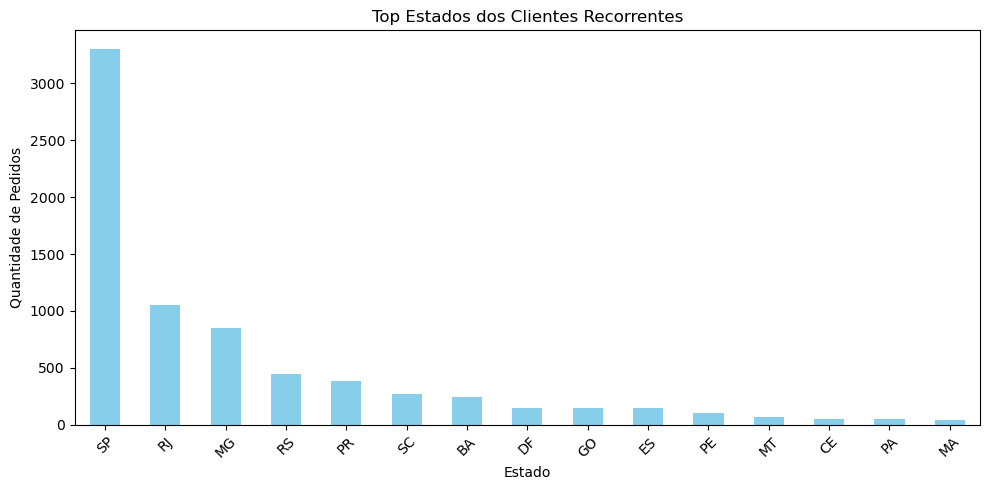

In [18]:
# Gráfico dos estados mais recorrentes entre clientes recorrentes
plt.figure(figsize=(10, 5))
clientes_recorrentes_clean['customer_state'].value_counts().head(15).plot(kind='bar', color='skyblue')
plt.title('Top Estados dos Clientes Recorrentes')
plt.xlabel('Estado')
plt.ylabel('Quantidade de Pedidos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

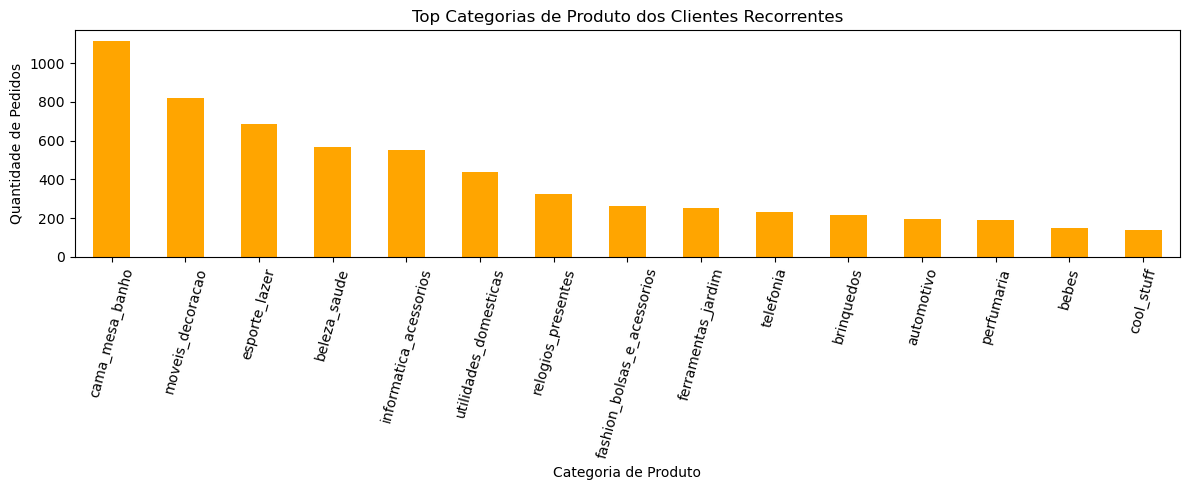

In [19]:
# Gráfico das categorias de produto mais recorrentes entre clientes recorrentes
plt.figure(figsize=(12, 5))
clientes_recorrentes_clean['product_category_name'].value_counts().head(15).plot(kind='bar', color='orange')
plt.title('Top Categorias de Produto dos Clientes Recorrentes')
plt.xlabel('Categoria de Produto')
plt.ylabel('Quantidade de Pedidos')
plt.xticks(rotation=75)
plt.tight_layout()
plt.show()

- Com essas informações podemos tirar insights valiosos para aumentar a fidelização de clientes  

- Poderia-se por exemplo investir mais no marketing de produtos de "cama_mesa_banho", "moveis_decoracao", "esportes_lazer" que lideram as recompras  

- Também poderiamos aumentar o número de anúncios para clientes do sudeste (principalmente sao paulo) que possuem uma fidelização maior


#### b) **Predição de Atraso**

- Será criada uma nova coluna denominada "atraso" que retornará 1 caso o produto esteja atrasado e 0 caso contrário. Para criar essa coluna comparei os  
atributos "order_delivered_customer_date" e "order_estimated_delivery_date", caso a primeira passe da segunda temos um atraso. 

- Apesar de ser um problema de decisão binária não utilizarei a **regressão linear** pois os dados não seguem um padrão linear, por isso optarei pela **random forest**  
devido ao seu caráter mais robusto em relação as relações complexas dos dados  

- Para treinar o modelo utilizarei toda a tabela "orders", toda a tabela "products", os atributos 'seller_city' e 'seller_state' da tabela "sellers", os atributos  
'customer_city' e 'customer_state' da tabela "customers", o 'review_score' da tabela "order_reviews", e o 'payment_value' da tabela "order_payments"

In [20]:
from sklearn.preprocessing import LabelEncoder

# Converter as colunas para datetime, se ainda não estiverem
orders_df['order_estimated_delivery_date'] = pd.to_datetime(orders_df['order_estimated_delivery_date'])
orders_df['order_delivered_carrier_date' ] = pd.to_datetime(orders_df['order_delivered_carrier_date'])

# Criar a coluna "atraso"
orders_df['atraso'] = (
    (orders_df['order_delivered_customer_date'] > orders_df['order_estimated_delivery_date'])
    & orders_df['order_delivered_customer_date'].notnull()
    & orders_df['order_estimated_delivery_date'].notnull()
).astype(int)

orders_df.head(30)

orders_items = orders_df.merge(order_items_df[['order_id','seller_id', 'product_id']], on='order_id', how='inner')
orders_items_products = orders_items.merge(products_df, on='product_id', how='inner')
orders_items_products_sellers = orders_items_products.merge(sellers_df[['seller_id', 'seller_city','seller_state']], on='seller_id', how='inner')
orders_items_products_sellers_customers = orders_items_products_sellers.merge(customers_df[['customer_id','customer_unique_id', 'customer_city', 'customer_state']], on='customer_id', how='inner')
orders_items_products_sellers_customers_reviews = orders_items_products_sellers_customers.merge(order_reviews_df[['order_id', 'review_score']], on='order_id', how='inner')


le_seller_city = LabelEncoder()
le_seller_state = LabelEncoder()
le_customer_city = LabelEncoder()
le_customer_state = LabelEncoder()

orders_items_products_sellers_customers_reviews['seller_city_encoded'] = le_seller_city.fit_transform(
    orders_items_products_sellers_customers_reviews['seller_city'].astype(str)
)
orders_items_products_sellers_customers_reviews['seller_state_encoded'] = le_seller_state.fit_transform(
    orders_items_products_sellers_customers_reviews['seller_state'].astype(str)
)
orders_items_products_sellers_customers_reviews['customer_city_encoded'] = le_customer_city.fit_transform(
    orders_items_products_sellers_customers_reviews['customer_city'].astype(str)
)
orders_items_products_sellers_customers_reviews['customer_state_encoded'] = le_customer_state.fit_transform(
    orders_items_products_sellers_customers_reviews['customer_state'].astype(str)
)

orders_items_products_sellers_customers_reviews.head()

orders_items_products_sellers_customers_reviews.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
mes                                       int32
tempo_de_entrega                          int64
atraso                                    int64
seller_id                                object
product_id                               object
product_category_name                    object
product_name_lenght                     float64
product_description_lenght              float64
product_photos_qty                      float64
product_weight_g                        float64
product_length_cm                       float64
product_height_cm                       float64
product_width_cm                        

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Seleciona as colunas de features (removendo variáveis que não serão usadas diretamente)
features = orders_items_products_sellers_customers_reviews.drop(columns=['atraso', 'order_id', 'customer_id', 'product_id', 'seller_id', 'customer_unique_id'])
# Remove colunas que não são do tipo int, float ou bool
features = features.select_dtypes(include=['int', 'float', 'bool'])

# Variável alvo
target = orders_items_products_sellers_customers_reviews['atraso']

# Divisão em treino e teste (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)

features.dtypes

mes                             int32
tempo_de_entrega                int64
product_name_lenght           float64
product_description_lenght    float64
product_photos_qty            float64
product_weight_g              float64
product_length_cm             float64
product_height_cm             float64
product_width_cm              float64
review_score                    int64
seller_city_encoded             int64
seller_state_encoded            int64
customer_city_encoded           int64
customer_state_encoded          int64
dtype: object

In [22]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Ajuste do modelo Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# Previsão no conjunto de teste
y_pred = rf.predict(X_test)

# Avaliação do modelo
print("Acurácia:", accuracy_score(y_test, y_pred))


Acurácia: 0.9666740823136819


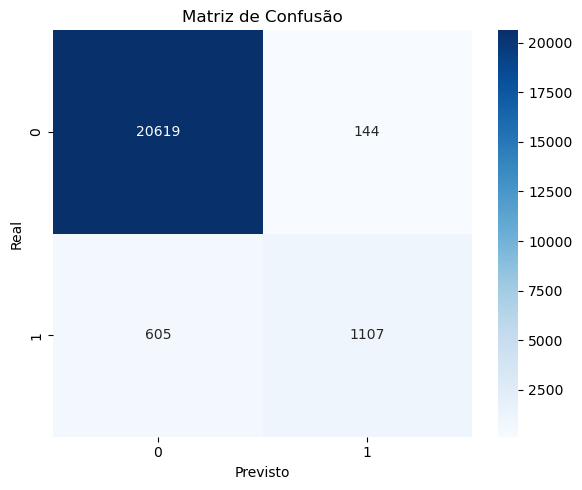

In [23]:
# Matriz de confusão visual
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.title('Matriz de Confusão')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.tight_layout()
plt.show()

In [24]:
# Relatório de Classificação
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred))


Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98     20763
           1       0.88      0.65      0.75      1712

    accuracy                           0.97     22475
   macro avg       0.93      0.82      0.86     22475
weighted avg       0.96      0.97      0.96     22475



/tmp/ipykernel_28776/887398502.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=importances_df.head(10), palette='viridis')


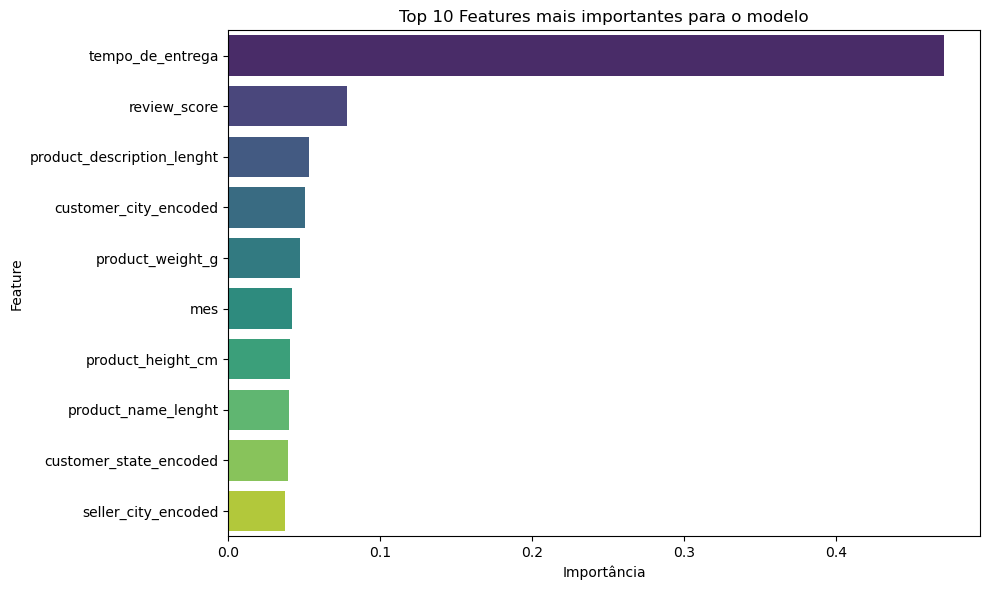

In [25]:
# Análise dos resultados - Importância das variáveis
importances = rf.feature_importances_
feature_names = features.columns
importances_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
importances_df = importances_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=importances_df.head(10), palette='viridis')
plt.title('Top 10 Features mais importantes para o modelo')
plt.xlabel('Importância')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

- Tivemos uma ótima performace do modelo, e como esperado a variável **tempo_de_entrega** foi a mais importante para a decisão 

#### c) **Segmentação de Clientes**

- Essa clusterização buscará avaliar comportamentos de compra, por isso dados relevantes para a clusterização: "order_id", "categoria do produto", "payment_value", "recorrencia"  

- Reutilizarei o código em **1 Análise de Retenção** para criar uma coluna que determina se o cliente é fidelizado ou não

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pandas as pd
import seaborn as sns

#clientes_recorrentes_ids

segmentacao_de_clientes = orders_items_products_sellers_customers[['order_id', 'product_category_name', 'customer_unique_id']]
segmentacao_de_clientes = segmentacao_de_clientes.merge(order_payments_df[['order_id', 'payment_value']], on='order_id', how='inner')


segmentacao_de_clientes['loyal_customer'] = segmentacao_de_clientes['customer_unique_id'].isin(clientes_recorrentes_ids).astype(int)
segmentacao_de_clientes.head()
segmentacao_de_clientes['loyal_customer'].value_counts()
segmentacao_de_clientes = segmentacao_de_clientes.drop(columns=['order_id'])


# Agrupa dados por cliente
agg_clientes = segmentacao_de_clientes.groupby('customer_unique_id').agg({
    'payment_value': 'mean',  # valor médio pago
    'product_category_name': lambda x: x.mode()[0] if not x.mode().empty else 'unknown',  # categoria mais comprada
    'loyal_customer': 'max'  # se é recorrente (0 ou 1)
}).reset_index()

# Transforma categoria em variáveis dummies
agg_clientes_dummies = pd.get_dummies(agg_clientes, columns=['product_category_name'], drop_first=True)



In [27]:

# Normaliza os dados (exceto customer_id)
scaler = StandardScaler()
X = scaler.fit_transform(agg_clientes_dummies.drop(columns=['customer_unique_id']))

# Aplica KMeans
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
agg_clientes_dummies['cluster'] = kmeans.fit_predict(X)

# Junta o cluster de volta na segmentacao_de_clientes, se quiser
segmentacao_de_clientes = segmentacao_de_clientes.merge(
    agg_clientes_dummies[['customer_unique_id', 'cluster']],
    on='customer_unique_id',
    how='left'
)

# Visualiza a distribuição de clientes por cluster
print(agg_clientes_dummies['cluster'].value_counts())


cluster
3    83816
0     5587
2     3794
1     2222
Name: count, dtype: int64


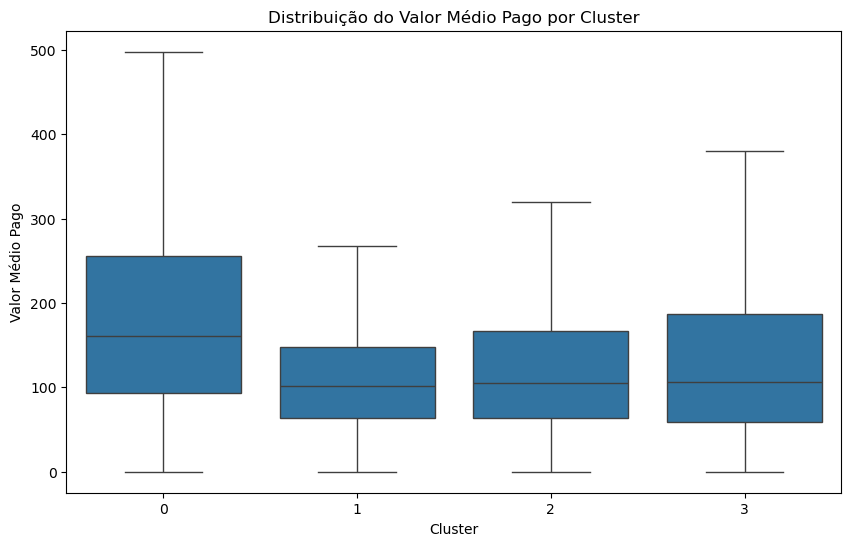

In [28]:

import matplotlib.pyplot as plt

# Visualização dos clusters em relação ao valor médio pago e fidelidade
plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster', y='payment_value', data=segmentacao_de_clientes, showfliers=False)
plt.title('Distribuição do Valor Médio Pago por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Valor Médio Pago')
plt.show()

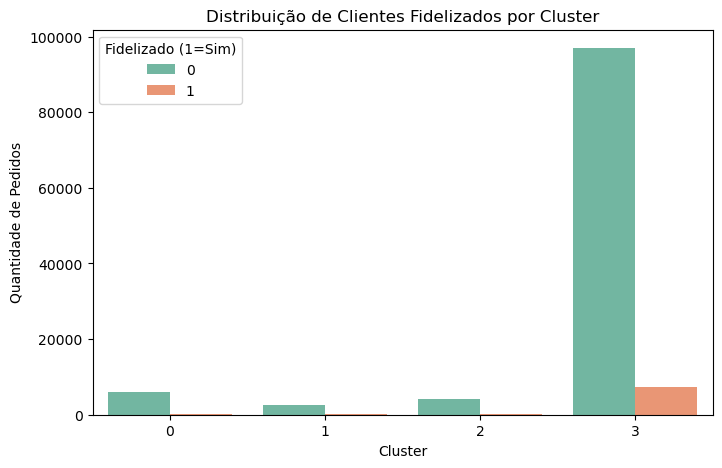

In [29]:
plt.figure(figsize=(8, 5))
sns.countplot(x='cluster', hue='loyal_customer', data=segmentacao_de_clientes, palette='Set2')
plt.title('Distribuição de Clientes Fidelizados por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Quantidade de Pedidos')
plt.legend(title='Fidelizado (1=Sim)')
plt.show()

In [30]:
# Análise dos clusters
for cluster_id in sorted(segmentacao_de_clientes['cluster'].unique()):
    grupo = segmentacao_de_clientes[segmentacao_de_clientes['cluster'] == cluster_id]
    pct_fidelizados = grupo['loyal_customer'].mean() * 100
    valor_medio = grupo['payment_value'].mean()
    categoria_top = grupo['product_category_name'].mode()[0] if not grupo['product_category_name'].mode().empty else 'unknown'
    print(f"Cluster {cluster_id}:")
    print(f"  - % Clientes Fidelizados: {pct_fidelizados:.1f}%")
    print(f"  - Valor Médio Pago: R$ {valor_medio:.2f}")
    print(f"  - Categoria Mais Comprada: {categoria_top}")
    # Estratégias de marketing sugeridas
    if pct_fidelizados > 50 and valor_medio > segmentacao_de_clientes['payment_value'].mean():
        print("  Estratégia: Investir em programas de fidelidade premium e ofertas exclusivas para manter e aumentar o ticket médio.")
    elif pct_fidelizados > 50:
        print("  Estratégia: Oferecer recompensas por recorrência e descontos progressivos para estimular compras de maior valor.")
    elif valor_medio > segmentacao_de_clientes['payment_value'].mean():
        print("  Estratégia: Focar em campanhas de upsell/cross-sell e benefícios para primeira recompra.")
    else:
        print("  Estratégia: Campanhas de aquisição, cupons de boas-vindas e comunicação focada em benefícios do produto.")
    print("-" * 60)

Cluster 0:
  - % Clientes Fidelizados: 4.1%
  - Valor Médio Pago: R$ 299.32
  - Categoria Mais Comprada: relogios_presentes
  Estratégia: Focar em campanhas de upsell/cross-sell e benefícios para primeira recompra.
------------------------------------------------------------
Cluster 1:
  - % Clientes Fidelizados: 3.6%
  - Valor Médio Pago: R$ 120.56
  - Categoria Mais Comprada: papelaria
  Estratégia: Campanhas de aquisição, cupons de boas-vindas e comunicação focada em benefícios do produto.
------------------------------------------------------------
Cluster 2:
  - % Clientes Fidelizados: 7.0%
  - Valor Médio Pago: R$ 145.26
  - Categoria Mais Comprada: brinquedos
  Estratégia: Campanhas de aquisição, cupons de boas-vindas e comunicação focada em benefícios do produto.
------------------------------------------------------------
Cluster 3:
  - % Clientes Fidelizados: 7.1%
  - Valor Médio Pago: R$ 167.43
  - Categoria Mais Comprada: cama_mesa_banho
  Estratégia: Campanhas de aquisição

#### d) **Análise de Satisfação**

- Para resolver essa questão utilizarei a **correlação de pearson** entre os atributos escolhidos, no entanto nem todos os atributos são númericos(condicao necessária para aplicar a relação), por isso a coluna "product_category_name" será codificada para valores númericos.  

- Vale ressaltar que este tipo de prática está longe de ser ideal, mas "resolve" o nosso problema

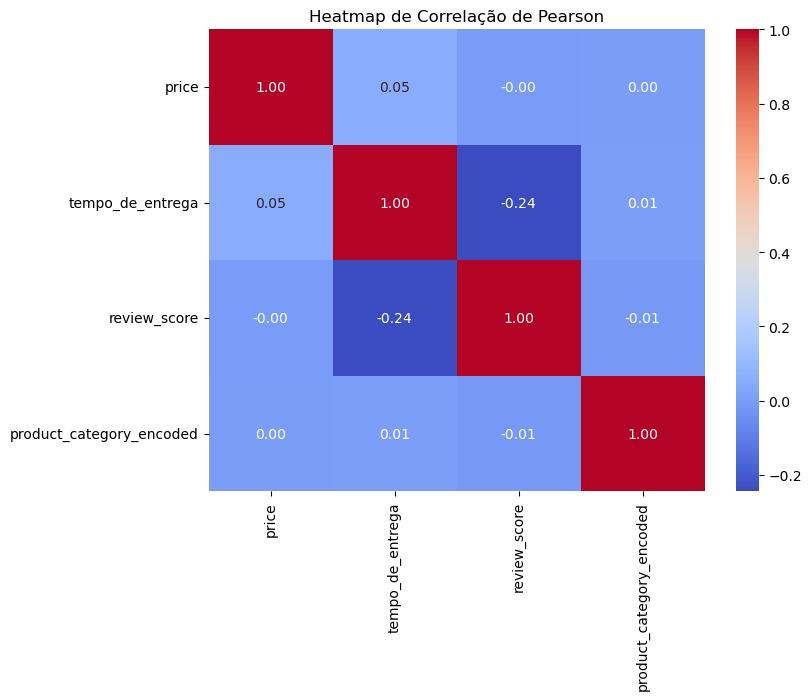

In [31]:
from sklearn.preprocessing import LabelEncoder

#nota de avaliação, categoria do produto, tempo de entrega, valor do pedido

order_items_products_clean = order_items_products.drop(columns=['real_price', 'order_item_id'])
items_products_orders = order_items_products_clean.merge(orders_df[['order_id', 'tempo_de_entrega']], on='order_id', how='inner')
items_products_orders_reviews = items_products_orders.merge(order_reviews_df[['order_id', 'review_score']], on='order_id', how='inner')
items_products_orders_reviews.head()

le = LabelEncoder()
items_products_orders_reviews['product_category_encoded'] = le.fit_transform(
    items_products_orders_reviews['product_category_name'].astype(str)
)

items_products_orders_reviews = items_products_orders_reviews.drop(columns=['product_category_name', 'order_id'])

# Calculando a correlação de Pearson
correlacao = items_products_orders_reviews.corr(method='pearson')

# Exibindo o heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlacao, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap de Correlação de Pearson')
plt.show()



- Podemos perceber que **baixa** é a relação entre os atributos escolhidos e a satisfação do cliente, somente o tempo de entrega que possui uma correlação negativa  
pequena sobre a satisfação, ou seja quanto menor o tempo de entrega maior a satisfação do cliente 

--- 

## 4. Visualização e Dashboards

---

#### a) **Evolução das vendas ao longo do tempo**

- O estado de referência será o estado em que a venda foi efetuada, ou seja "seller_state"

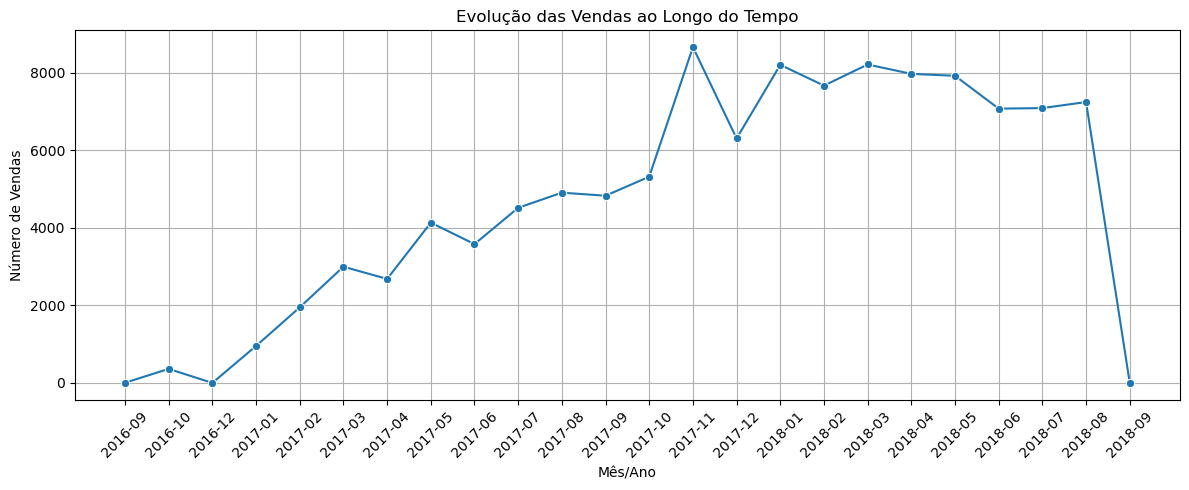

In [32]:

import matplotlib.pyplot as plt
import seaborn as sns

# Agrupar por mês e contar número de vendas

orders_items_products_sellers['mes_ano'] = orders_items_products_sellers['order_purchase_timestamp'].dt.to_period('M')
vendas_por_mes = orders_items_products_sellers[['order_id', 'seller_id', 'order_purchase_timestamp', 'product_category_name', 'seller_state', 'tempo_de_entrega','mes_ano']].groupby('mes_ano').size().reset_index(name='num_vendas')
vendas_por_mes['mes_ano'] = vendas_por_mes['mes_ano'].astype(str)

# Plotar o gráfico
plt.figure(figsize=(12, 5))
sns.lineplot(data=vendas_por_mes, x='mes_ano', y='num_vendas', marker='o')
plt.title('Evolução das Vendas ao Longo do Tempo')
plt.xlabel('Mês/Ano')
plt.ylabel('Número de Vendas')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


- infelizmente os widgets de filtro não estão funcionando mas o gráfico saiu de maneira correta

#### b) **Concentração de vendas por região/estado do Brasil**

In [33]:
orders_customers_geolocation = orders_customers[['order_id','customer_zip_code_prefix']].merge(geolocation_df[['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng']], 
                                                      left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix', how='inner')

vendas_com_latitude_longitude = orders_customers_geolocation[['order_id', 'geolocation_lat', 'geolocation_lng']]

display(vendas_com_latitude_longitude.head(30))

# Amostra para evitar sobrecarga de memória (opcional)
sample_size = 10000
vendas_sample = vendas_com_latitude_longitude.sample(n=sample_size, random_state=42)
vendas_sample = vendas_sample.dropna(subset=['geolocation_lat', 'geolocation_lng'])

# Criar o mapa centralizado no Brasil
m = folium.Map(location=[-14.2350, -51.9253], zoom_start=4)

# Adicionar o HeatMap
HeatMap(
    data=vendas_sample[['geolocation_lat', 'geolocation_lng']].values,
    radius=6,
    blur=8,
    min_opacity=0.2,
    max_zoom=1
).add_to(m)

m

,order_id,geolocation_lat,geolocation_lng
0,e481f51cbdc54678b7cc49136f2d6af7,-23.574809,-46.587471
1,e481f51cbdc54678b7cc49136f2d6af7,-23.578333,-46.587123
2,e481f51cbdc54678b7cc49136f2d6af7,-23.574809,-46.587471
3,e481f51cbdc54678b7cc49136f2d6af7,-23.575033,-46.587451
4,e481f51cbdc54678b7cc49136f2d6af7,-23.580054,-46.586673
5,e481f51cbdc54678b7cc49136f2d6af7,-23.578333,-46.587123
6,e481f51cbdc54678b7cc49136f2d6af7,-23.574809,-46.587471
7,e481f51cbdc54678b7cc49136f2d6af7,-23.576281,-46.587276
8,e481f51cbdc54678b7cc49136f2d6af7,-23.573954,-46.587331
9,e481f51cbdc54678b7cc49136f2d6af7,-23.579628,-46.586714


#### c) **Relação avaliação do cliente x tempo de entrega**

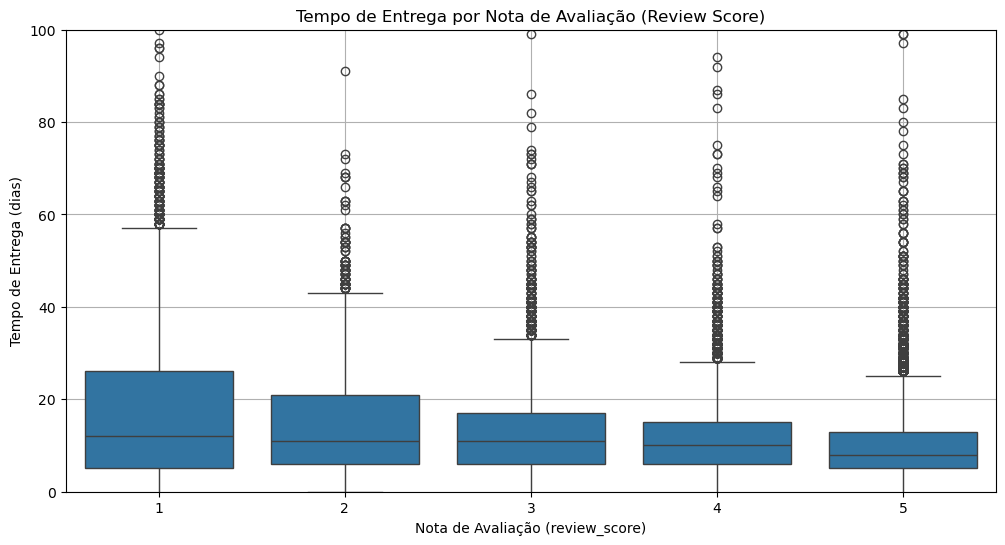

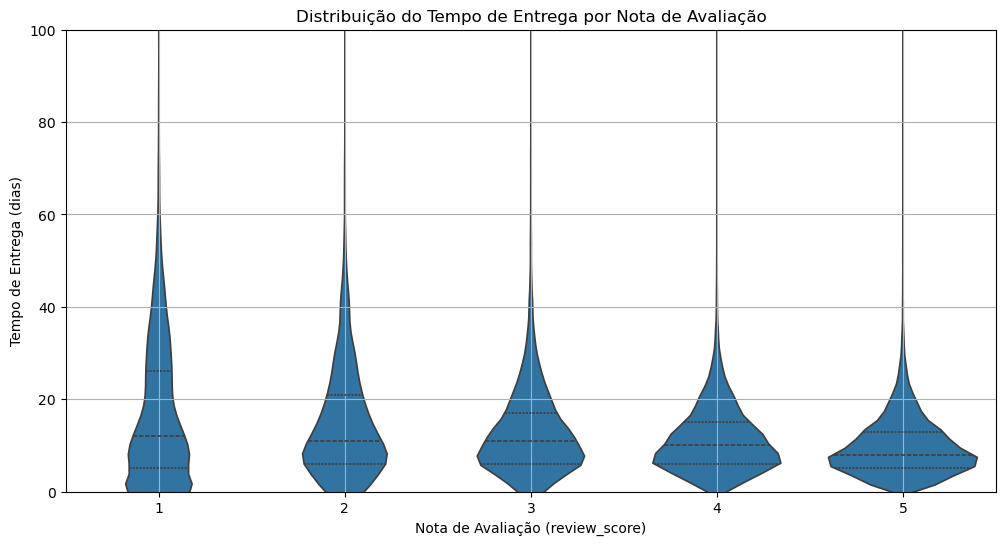

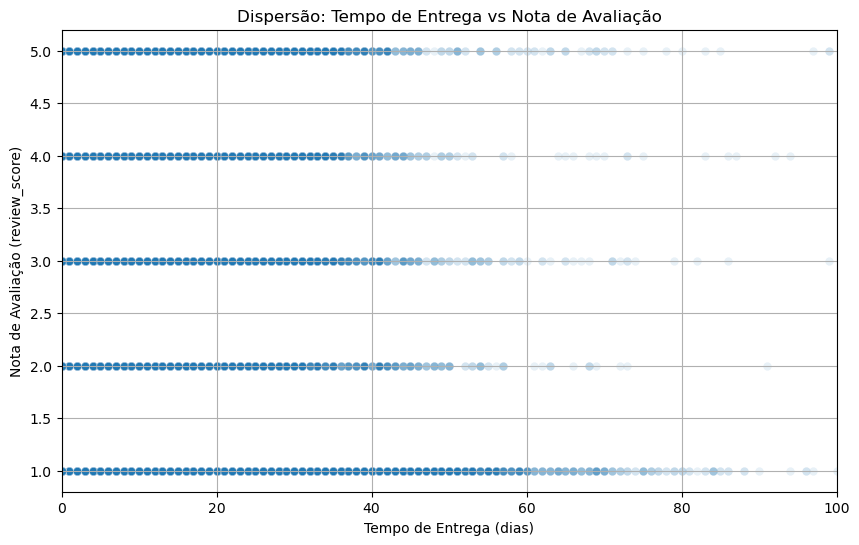

In [34]:
orders_reviews = orders_df[['order_id', 'tempo_de_entrega']].merge(
    order_reviews_df[['order_id', 'review_score']], on='order_id', how='inner')

orders_reviews.head(10)

plt.figure(figsize=(12, 6))
sns.boxplot(x='review_score', y='tempo_de_entrega', data=orders_reviews)
plt.ylim(0, 100)
plt.title('Tempo de Entrega por Nota de Avaliação (Review Score)')
plt.xlabel('Nota de Avaliação (review_score)')
plt.ylabel('Tempo de Entrega (dias)')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
sns.violinplot(x='review_score', y='tempo_de_entrega', data=orders_reviews, inner='quartile')
plt.ylim(0, 100)
plt.title('Distribuição do Tempo de Entrega por Nota de Avaliação')
plt.xlabel('Nota de Avaliação (review_score)')
plt.ylabel('Tempo de Entrega (dias)')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='tempo_de_entrega', y='review_score', data=orders_reviews, alpha=0.1)
plt.xlim(0, 100)
plt.title('Dispersão: Tempo de Entrega vs Nota de Avaliação')
plt.xlabel('Tempo de Entrega (dias)')
plt.ylabel('Nota de Avaliação (review_score)')
plt.grid(True)
plt.show()


- É possível notar que pouca é a diferença entre o tempo de entrega para as notas 3, 4 e 5. No entanto, para as notas 1 e 2 podemos perceber um crescimento do tempo de entrega  

- Principalmente a partir do gráfico de violino podemos perceber a relação entre as duas variáveis


#### d) **Dashboards de análise dos vendedores**

- Como temos 3090 vendedores distintos (ao realizarmos o merge das tabelas) vamos diminuir os escopo da nossa análise para os 50 "maiores" vendedores que são os 50  
com a maior quantidade de pedidos. Isso será feito por conta da relevância desses vendedores no dataset.  


- Poderiamos mostrar os top 50 vendedores considerando somente as "melhores avaliações" no entanto isso favoreceria vendedores com poucas vendas ou seja teriamos as "melhores avliações" de vendedores que venderam 1 a 5 produtos que é um volume irrelevante para o dataset. O mesmo vale para o tempo de entrega.

- Infelizmente não temos o nome dos vendedores o que torna os gráficos "poluídos". Poderiamos atribuir um "apelido" a cada vendedor ganhariamos legibilidade em detrimento da informação de quem são de fato os top 50 

In [35]:
# volume de vendas, satisfação do cliente e tempo de entrega
analise_dos_vendedores = orders_items_products_sellers[['order_id', 'seller_id', 'tempo_de_entrega' ]]
analise_dos_vendedores = analise_dos_vendedores.merge(order_reviews_df[['order_id', 'review_score']], on='order_id', how='inner')

# Quantidade de vendedores distintos
num_sellers = analise_dos_vendedores['seller_id'].nunique()
print(f"Número de seller_id distintos: {num_sellers}")


Número de seller_id distintos: 3090


/tmp/ipykernel_28776/709862107.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_25.index, y=top_25.values, palette='viridis')


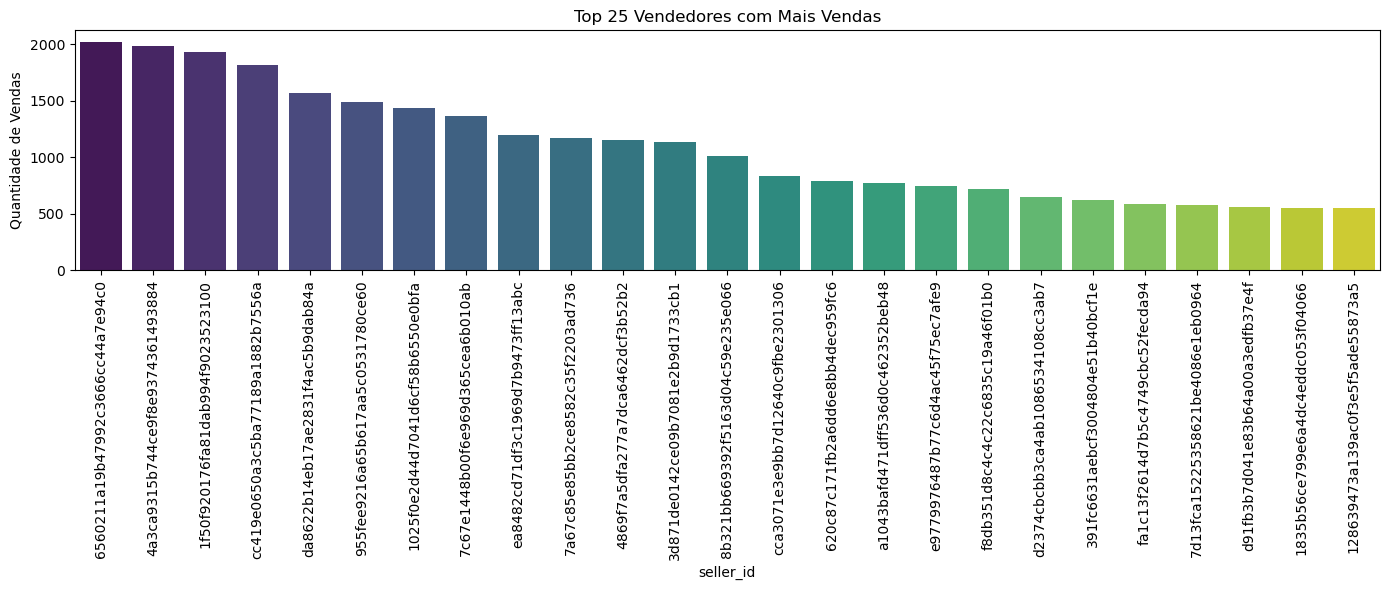

In [36]:

top_25 = analise_dos_vendedores['seller_id'].value_counts().head(25)
plt.figure(figsize=(14, 6))
sns.barplot(x=top_25.index, y=top_25.values, palette='viridis')
plt.title('Top 25 Vendedores com Mais Vendas')
plt.xlabel('seller_id')
plt.ylabel('Quantidade de Vendas')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


/tmp/ipykernel_28776/534973688.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=media_reviews_top_25_sorted.index, y=media_reviews_top_25_sorted.values, palette='coolwarm')


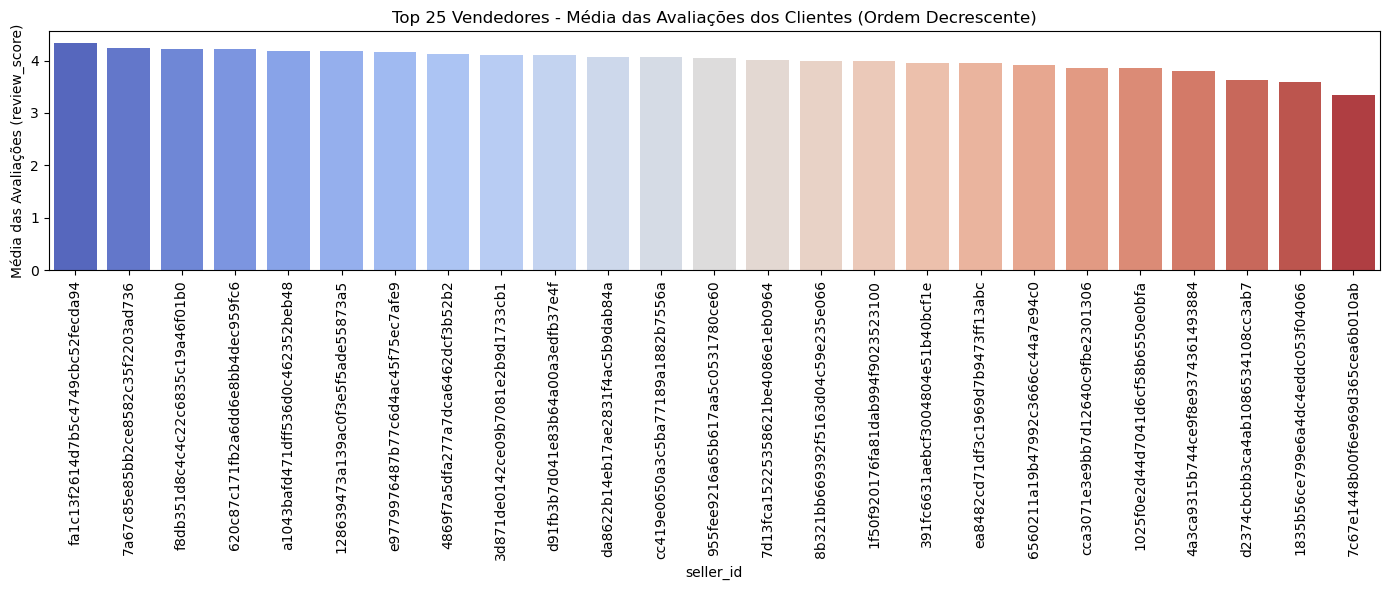

In [37]:

# Calcular a média das reviews para os top 25 vendedores
media_reviews_top_25 = (
    analise_dos_vendedores[analise_dos_vendedores['seller_id'].isin(top_25.index)]
    .groupby('seller_id')['review_score']
    .mean()
    .loc[top_25.index]  # mantém a ordem dos top_25
)

# Ordenar em ordem decrescente de média das avaliações
media_reviews_top_25_sorted = media_reviews_top_25.sort_values(ascending=False)

plt.figure(figsize=(14, 6))
sns.barplot(x=media_reviews_top_25_sorted.index, y=media_reviews_top_25_sorted.values, palette='coolwarm')
plt.title('Top 25 Vendedores - Média das Avaliações dos Clientes (Ordem Decrescente)')
plt.xlabel('seller_id')
plt.ylabel('Média das Avaliações (review_score)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


/tmp/ipykernel_28776/1876106880.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=media_tempo_entrega_top_25_sorted.index, y=media_tempo_entrega_top_25_sorted.values, palette='magma')


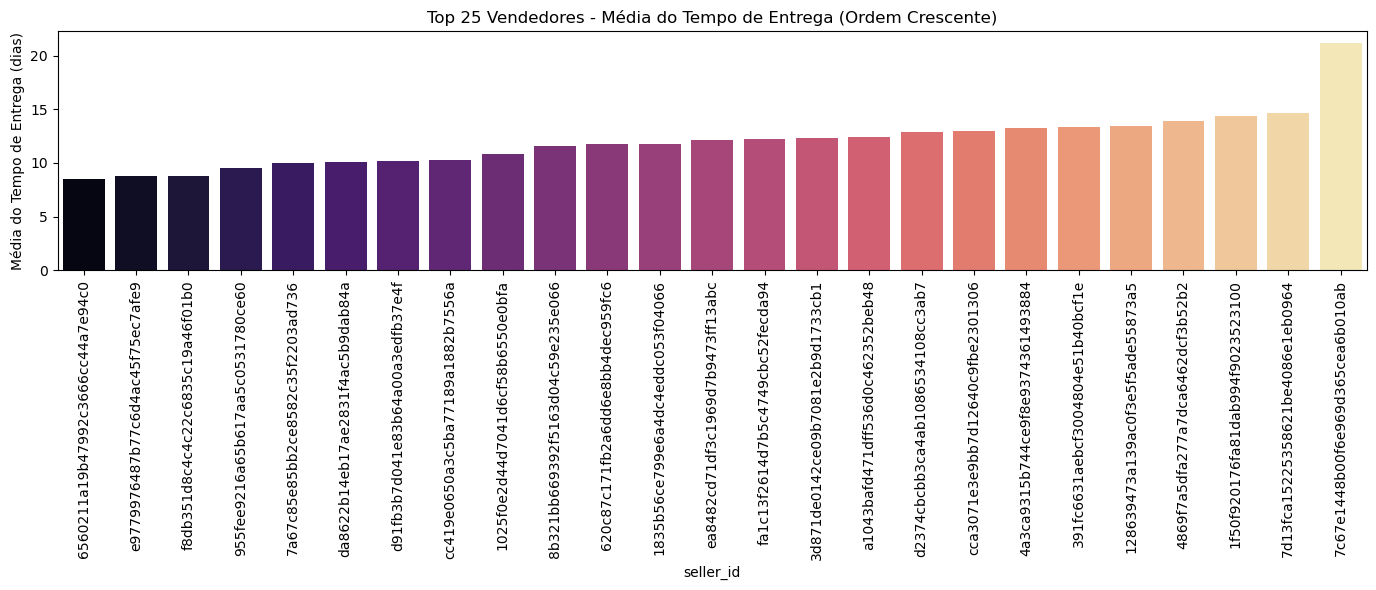

In [38]:

# Calcular a média do tempo de entrega para os top 25 vendedores
media_tempo_entrega_top_25 = (
    analise_dos_vendedores[analise_dos_vendedores['seller_id'].isin(top_25.index)]
    .groupby('seller_id')['tempo_de_entrega']
    .mean()
    .loc[top_25.index]  # mantém a ordem dos top_25
)
# Ordenar em ordem crescente de média do tempo de entrega
media_tempo_entrega_top_25_sorted = media_tempo_entrega_top_25.sort_values(ascending=True)
plt.figure(figsize=(14, 6))
sns.barplot(x=media_tempo_entrega_top_25_sorted.index, y=media_tempo_entrega_top_25_sorted.values, palette='magma')
plt.title('Top 25 Vendedores - Média do Tempo de Entrega (Ordem Crescente)')
plt.xlabel('seller_id')
plt.ylabel('Média do Tempo de Entrega (dias)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

